# PPO- based Pysc2

Modular Design
sc2_ppo_project/

├── main.py             # Entry-point to run training

├── config.py           # Hyperparameters and logging config

├── environment.py      # SC2 environment wrapper

├── model.py            # Actor-Critic neural network

├── utils.py            # Observation preprocessing and action utilities

└── ppo.py              # PPO training algorithm implementation



In [1]:
# config.py

In [33]:
import torch
import logging

# ─── Hyperparameters ─────────────────────────────
# MAP_NAME     = "CollectMineralsAndGas"
MAP_NAME     = "Simple64"

SCREEN_SIZE  = 84
MINIMAP_SIZE = 64
STEP_MUL     = 16
NB_ACTORS    = 1
T            = 128
K            = 10
BATCH_SIZE   = 256
GAMMA        = 0.99
GAE_LAMBDA   = 0.95
LR           = 2.5e-4
ENT_COEF     = 0.01
VF_COEF      = 1.0
MAX_ITERS    = 10000
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── Logging Configuration ──────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)


In [34]:
# env.py

In [35]:
from pysc2.env import sc2_env
from pysc2.lib import actions, features
# from config import MAP_NAME, SCREEN_SIZE, MINIMAP_SIZE, STEP_MUL, logger

class SC2Envs:
    def __init__(self, nb_actor):
        logger.info("Initializing %d SC2 env(s)...", nb_actor)
        self.nb   = nb_actor
        self.envs = [self._make_env() for _ in range(nb_actor)]
        self.obs  = [None]*nb_actor
        self.done = [False]*nb_actor
        self._init_all()
        logger.info("All SC2 env(s) ready.")

    def _make_env(self):
        return sc2_env.SC2Env(
            map_name=MAP_NAME,
            players=[sc2_env.Agent(sc2_env.Race.terran)],
            agent_interface_format=features.AgentInterfaceFormat(
                feature_dimensions=features.Dimensions(
                    screen=SCREEN_SIZE, minimap=MINIMAP_SIZE),
                use_feature_units=True,
                use_raw_units=False,
                use_camera_position=True,
                action_space=actions.ActionSpace.FEATURES
            ),
            step_mul=STEP_MUL,
            game_steps_per_episode=0,
            visualize=False,
        )

    def _init_all(self):
        for i, e in enumerate(self.envs):
            ts = e.reset()[0]
            self.obs[i], self.done[i] = ts, False

    def reset(self, i):
        ts = self.envs[i].reset()[0]
        self.obs[i], self.done[i] = ts, False
        return ts

    def step(self, i, fc):
        ts = self.envs[i].step([fc])[0]
        self.obs[i], self.done[i] = ts, ts.last()
        return ts

    def close(self):
        for e in self.envs:
            e.close()


In [61]:
#Multi Plaer Map

from pysc2.env import sc2_env
from pysc2.lib import actions, features
import logging

class SC2EnvsMulti:
    def __init__(self, nb_actor):
        logger.info("Initializing %d SC2 env(s)...", nb_actor)
        self.nb = nb_actor
        self.envs = [self._make_env() for _ in range(nb_actor)]
        self.obs = [env.reset()[0] for env in self.envs]
        self.done = [False] * nb_actor

    def _make_env(self):
        return sc2_env.SC2Env(
            map_name=MAP_NAME,
            players=[
                sc2_env.Agent(sc2_env.Race.terran),
                sc2_env.Bot(sc2_env.Race.terran, sc2_env.Difficulty.very_easy)

            ],
            agent_interface_format=features.AgentInterfaceFormat(
                feature_dimensions=features.Dimensions(
                    screen=SCREEN_SIZE, minimap=MINIMAP_SIZE),
                use_feature_units=True,
                use_raw_units=False,
                use_camera_position=True,
                action_space=actions.ActionSpace.FEATURES
            ),
            step_mul=STEP_MUL,
            game_steps_per_episode=0,
            visualize=False
        )

    def step(self, i, action):
        timestep = self.envs[i].step([action])[0]
        self.obs[i] = timestep
        self.done[i] = timestep.last()
        return timestep

    def reset(self, i):
        self.obs[i] = self.envs[i].reset()[0]
        self.done[i] = False

    def close(self):
        for env in self.envs:
            env.close()


In [51]:
# model.py

In [52]:
import torch
import torch.nn as nn
# from config import SCREEN_SIZE, DEVICE

class ActorCritic(nn.Module):
    def __init__(self, in_channels, nb_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, 8, stride=4), nn.Tanh(),
            nn.Conv2d(16, 32, 4, stride=2), nn.Tanh(),
            nn.Flatten(),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, SCREEN_SIZE, SCREEN_SIZE)
            conv_out = self.conv(dummy).shape[-1]

        self.fc     = nn.Sequential(nn.Linear(conv_out, 256), nn.Tanh())
        self.actor  = nn.Linear(256, nb_actions)
        self.critic = nn.Linear(256, 1)

    def forward(self, x):
        h = self.conv(x)
        h = self.fc(h)
        return self.actor(h), self.critic(h).squeeze(-1)


In [53]:
# utils.py

In [54]:
# import torch
# import numpy as np
# import random
# from pysc2.lib import actions, features
# # from config import DEVICE

# _PLAYER_RELATIVE = features.SCREEN_FEATURES.player_relative.index
# _UNIT_TYPE       = features.SCREEN_FEATURES.unit_type.index

# ACTION_LIST = ['do_nothing', 'select_idle', 'build_refinery', 'harvest']
# FUNC_ID = {
#     'do_nothing': actions.FUNCTIONS.no_op.id,
#     'select_idle': actions.FUNCTIONS.select_idle_worker.id,
#     'build_refinery': actions.FUNCTIONS.Build_Refinery_screen.id,
#     'harvest': actions.FUNCTIONS.Harvest_Gather_screen.id,
# }

# def preprocess(ts):
#     fs = ts.observation.feature_screen
#     pr = fs[_PLAYER_RELATIVE].astype(np.float32) / 4.0
#     ut = fs[_UNIT_TYPE].astype(np.float32) / fs[_UNIT_TYPE].max()
#     stacked = np.stack([pr, ut], axis=0)
#     return torch.from_numpy(stacked).unsqueeze(0).float().to(DEVICE)

# def legal_actions(ts):
#     avail = set(ts.observation.available_actions)
#     fus   = ts.observation.feature_units
#     legal = [0]
#     if FUNC_ID['select_idle'] in avail: legal.append(1)
#     if FUNC_ID['build_refinery'] in avail and any(u.unit_type==342 for u in fus): legal.append(2)
#     if FUNC_ID['harvest'] in avail and any(u.unit_type==341 for u in fus): legal.append(3)
#     return legal

# def make_pysc2_call(action_idx, ts):
#     name, fid = ACTION_LIST[action_idx], FUNC_ID[ACTION_LIST[action_idx]]
#     if name == 'select_idle':
#         return actions.FunctionCall(fid, [[2]])
#     if name in ('build_refinery','harvest'):
#         fus = ts.observation.feature_units
#         cand = [u for u in fus if (u.unit_type==342 if name=='build_refinery' else u.unit_type==341)]
#         if not cand:
#             return actions.FunctionCall(actions.FUNCTIONS.no_op.id, [])
#         u = random.choice(cand)
#         return actions.FunctionCall(fid, [[0],[u.x,u.y]])
#     return actions.FunctionCall(fid, [])


In [55]:
import torch
import numpy as np
import random
from pysc2.lib import actions, features

_PLAYER_RELATIVE = features.SCREEN_FEATURES.player_relative.index
_UNIT_TYPE = features.SCREEN_FEATURES.unit_type.index

ACTION_LIST = ['do_nothing', 'move', 'attack', 'build', 'gather', 'upgrade', 'train']
ACTION_INDEX = {name: idx for idx, name in enumerate(ACTION_LIST)}

SCREEN_SIZE = 84

# Terran building unit_type IDs (partial list — expand as needed)
TERRAN_STRUCTURE_TYPES = [
    18,   # CommandCenter
    20,   # SupplyDepot
    21,   # Barracks
    22,   # EngineeringBay
    23,   # MissileTurret
    24,   # Bunker
    25,   # Refinery
    27,   # Factory
    28,   # GhostAcademy
    29,   # Starport
    30,   # Armory
    130, 131, 132, 133  # Tech lab, Reactor, etc.
]

def safe_coords(x, y, screen_size=SCREEN_SIZE):
    x = max(0, min(screen_size - 1, x))
    y = max(0, min(screen_size - 1, y))
    return [x, y]

def preprocess(ts):
    fs = ts.observation.feature_screen
    pr = fs[_PLAYER_RELATIVE].astype(np.float32) / 4.0
    ut = fs[_UNIT_TYPE].astype(np.float32) / fs[_UNIT_TYPE].max()
    stacked = np.stack([pr, ut], axis=0)
    return torch.from_numpy(stacked).unsqueeze(0).float()

def legal_actions(ts):
    avail = set(ts.observation.available_actions)
    fus = ts.observation.feature_units
    legal = [ACTION_INDEX['do_nothing']]

    if actions.FUNCTIONS.Move_screen.id in avail:
        legal.append(ACTION_INDEX['move'])

    if actions.FUNCTIONS.Attack_screen.id in avail:
        legal.append(ACTION_INDEX['attack'])

    if any('Build' in actions.FUNCTIONS[a].name for a in avail):
        legal.append(ACTION_INDEX['build'])

    if actions.FUNCTIONS.Harvest_Gather_screen.id in avail and any(u.unit_type == 341 for u in fus):
        legal.append(ACTION_INDEX['gather'])

    if any('Research' in actions.FUNCTIONS[a].name for a in avail):
        legal.append(ACTION_INDEX['upgrade'])

    if any('Train' in actions.FUNCTIONS[a].name for a in avail):
        legal.append(ACTION_INDEX['train'])

    return legal

def make_pysc2_call(action_idx, ts, pending=None):
    obs = ts.observation
    fus = obs.feature_units
    avail = set(obs.available_actions)

    if pending:
        if pending['action_fn'] in avail:
            args = pending['args']
            if len(args) > 1 and isinstance(args[1], list) and len(args[1]) == 2:
                x, y = args[1]
                return actions.FunctionCall(pending['action_fn'], [args[0], safe_coords(x, y)]), None
            else:
                return actions.FunctionCall(pending['action_fn'], args), None
        else:
            print(f"[SKIP] Function {pending['action_fn']} not available anymore.")
            return actions.FunctionCall(actions.FUNCTIONS.no_op.id, []), None

    # ── Train: Select building first ──
    if action_idx == ACTION_INDEX['train']:
        building_units = [u for u in fus if u.alliance == features.PlayerRelative.SELF and u.unit_type in TERRAN_STRUCTURE_TYPES]
        if not building_units or actions.FUNCTIONS.select_point.id not in avail:
            return actions.FunctionCall(actions.FUNCTIONS.no_op.id, []), None

        building = random.choice(building_units)
        select_coords = safe_coords(building.x, building.y)
        select_action = actions.FunctionCall(actions.FUNCTIONS.select_point.id, [[0], select_coords])

        train_actions = [a for a in avail if 'Train' in actions.FUNCTIONS[a].name]
        if train_actions:
            train_action = random.choice(train_actions)
            next_action = {'action_fn': train_action, 'args': [[0]]}
        else:
            next_action = None

        return select_action, next_action

    # ── Default: Select unit ──
    selectable_units = [u for u in fus if u.alliance == features.PlayerRelative.SELF]
    if not selectable_units or actions.FUNCTIONS.select_point.id not in avail:
        return actions.FunctionCall(actions.FUNCTIONS.no_op.id, []), None

    unit = random.choice(selectable_units)
    select_coords = safe_coords(unit.x, unit.y)
    select_action = actions.FunctionCall(actions.FUNCTIONS.select_point.id, [[0], select_coords])

    if action_idx == ACTION_INDEX['move'] and actions.FUNCTIONS.Move_screen.id in avail:
        x, y = np.random.randint(0, SCREEN_SIZE), np.random.randint(0, SCREEN_SIZE)
        next_action = {'action_fn': actions.FUNCTIONS.Move_screen.id, 'args': [[0], [x, y]]}

    elif action_idx == ACTION_INDEX['attack'] and actions.FUNCTIONS.Attack_screen.id in avail:
        enemies = [u for u in fus if u.alliance == features.PlayerRelative.ENEMY]
        if enemies:
            target = random.choice(enemies)
            next_action = {'action_fn': actions.FUNCTIONS.Attack_screen.id, 'args': [[0], [target.x, target.y]]}
        else:
            next_action = None

    elif action_idx == ACTION_INDEX['gather'] and actions.FUNCTIONS.Harvest_Gather_screen.id in avail:
        minerals = [u for u in fus if u.unit_type == 341]
        if minerals:
            target = random.choice(minerals)
            next_action = {'action_fn': actions.FUNCTIONS.Harvest_Gather_screen.id, 'args': [[0], [target.x, target.y]]}
        else:
            next_action = None

    elif action_idx == ACTION_INDEX['build']:
        build_actions = [a for a in avail if 'Build' in actions.FUNCTIONS[a].name]
        if build_actions:
            build_action = random.choice(build_actions)
            buildable = np.argwhere(obs.feature_screen.buildable == 1)
            if buildable.size > 0:
                y, x = random.choice(buildable)
                next_action = {'action_fn': build_action, 'args': [[0], [x, y]]}
            else:
                next_action = None
        else:
            next_action = None

    elif action_idx == ACTION_INDEX['upgrade']:
        upgrade_actions = [a for a in avail if 'Research' in actions.FUNCTIONS[a].name]
        if upgrade_actions:
            upgrade_action = random.choice(upgrade_actions)
            next_action = {'action_fn': upgrade_action, 'args': [[0]]}
        else:
            next_action = None

    else:
        next_action = None

    return select_action, next_action

def make_pysc2_call_core(action_idx, ts):
    obs = ts.observation
    fus = obs.feature_units
    avail = set(obs.available_actions)

    if action_idx == ACTION_INDEX['do_nothing']:
        return actions.FunctionCall(actions.FUNCTIONS.no_op.id, []), None

    if action_idx == ACTION_INDEX['move'] and actions.FUNCTIONS.Move_screen.id in avail:
        x, y = np.random.randint(0, SCREEN_SIZE), np.random.randint(0, SCREEN_SIZE)
        return actions.FunctionCall(actions.FUNCTIONS.Move_screen.id, [[0], safe_coords(x, y)]), None

    if action_idx == ACTION_INDEX['attack'] and actions.FUNCTIONS.Attack_screen.id in avail:
        enemies = [u for u in fus if u.alliance == features.PlayerRelative.ENEMY]
        if enemies:
            target = random.choice(enemies)
            return actions.FunctionCall(actions.FUNCTIONS.Attack_screen.id, [[0], safe_coords(target.x, target.y)]), None

    if action_idx == ACTION_INDEX['build']:
        build_actions = [a for a in avail if 'Build' in actions.FUNCTIONS[a].name]
        if build_actions:
            build_action = random.choice(build_actions)
            buildable = np.argwhere(obs.feature_screen.buildable == 1)
            if buildable.size > 0:
                y, x = random.choice(buildable)
                return actions.FunctionCall(build_action, [[0], safe_coords(x, y)]), None

    if action_idx == ACTION_INDEX['gather'] and actions.FUNCTIONS.Harvest_Gather_screen.id in avail:
        minerals = [u for u in fus if u.unit_type == 341]
        if minerals:
            target = random.choice(minerals)
            return actions.FunctionCall(actions.FUNCTIONS.Harvest_Gather_screen.id, [[0], safe_coords(target.x, target.y)]), None

    if action_idx == ACTION_INDEX['upgrade']:
        upgrade_actions = [a for a in avail if 'Research' in actions.FUNCTIONS[a].name]
        if upgrade_actions:
            upgrade_action = random.choice(upgrade_actions)
            return actions.FunctionCall(upgrade_action, [[0]]), None

    if action_idx == ACTION_INDEX['train']:
        train_actions = [a for a in avail if 'Train' in actions.FUNCTIONS[a].name]
        if train_actions:
            train_action = random.choice(train_actions)
            return actions.FunctionCall(train_action, [[0]]), None

    return actions.FunctionCall(actions.FUNCTIONS.no_op.id, []), None


In [56]:
# PPO training LOOP

In [57]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from pysc2.lib import actions
from config import *
# from utils import preprocess, legal_actions, make_pysc2_call


# ─── PPO Training ────────────────────────────────────────────────────────────
def PPO(envs, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=1.0, end_factor=0.0, total_iters=MAX_ITERS
    )

    ep_rewards = []       # final cumulative score of each episode
    last_score = [0]*envs.nb

    logger.info("▶️  Starting PPO for %d iterations", MAX_ITERS)
    for it in range(MAX_ITERS):
        if it % 1000 == 0:
            logger.info("🔄 Iter %d / %d", it, MAX_ITERS)

        # storage buffers
        obs_buf  = torch.zeros(envs.nb, T, 2, SCREEN_SIZE, SCREEN_SIZE, device=DEVICE)
        act_buf  = torch.zeros(envs.nb, T,      dtype=torch.long, device=DEVICE)
        logp_buf = torch.zeros(envs.nb, T,                     device=DEVICE)
        val_buf  = torch.zeros(envs.nb, T+1,                   device=DEVICE)
        rew_buf  = torch.zeros(envs.nb, T,                     device=DEVICE)
        done_buf = torch.zeros(envs.nb, T,                     device=DEVICE)
        adv_buf  = torch.zeros(envs.nb, T,                     device=DEVICE)

        # ─── Rollout ─────────────────────────────────────────────────────────
        with torch.no_grad():
            for t in range(T):
                for i in range(envs.nb):
                    ts    = envs.obs[i]
                    state = preprocess(ts)
                    logits, value = model(state)

                    # mask illegal
                    LA   = legal_actions(ts)
                    mask = torch.full_like(logits, float('-inf'))
                    mask[0, LA] = 0.0
                    dist = Categorical(logits=logits + mask)

                    action = dist.sample()
                    logp   = dist.log_prob(action)
                    fc     = make_pysc2_call(action.item(), ts)

                    # step (fallback to no-op)
                    try:
                        ts2 = envs.step(i, fc)
                    except ValueError:
                        ts2 = envs.step(i,
                            actions.FunctionCall(actions.FUNCTIONS.no_op.id, []))

                    # ── reward = Δ score_cumulative ─────────────────
                    cur_score = int(ts2.observation['score_cumulative'][0])
                    r = cur_score - last_score[i]
                    last_score[i] = cur_score

                    d = float(ts2.last())

                    obs_buf[i,t]  = state
                    act_buf[i,t]  = action
                    logp_buf[i,t] = logp
                    val_buf[i,t]  = value
                    rew_buf[i,t]  = r
                    done_buf[i,t] = d

                    if d:
                        ep_rewards.append(cur_score)
                        last_score[i] = 0
                        envs.reset(i)

            # bootstrap final value
            for i in range(envs.nb):
                val_buf[i,T] = model(preprocess(envs.obs[i]))[1]

        # ─── GAE & flatten ────────────────────────────────────────────────────
        for i in range(envs.nb):
            gae = 0
            for t in reversed(range(T)):
                mask  = 1.0 - done_buf[i,t]
                delta = rew_buf[i,t] + GAMMA*val_buf[i,t+1]*mask - val_buf[i,t]
                gae   = delta + GAMMA*GAE_LAMBDA*mask*gae
                adv_buf[i,t] = gae

        b_s  = obs_buf.reshape(-1,2,SCREEN_SIZE,SCREEN_SIZE)
        b_a  = act_buf.reshape(-1)
        b_lp = logp_buf.reshape(-1)
        b_v  = val_buf[:,:T].reshape(-1)
        b_ad = adv_buf.reshape(-1)

        # ─── PPO updates ─────────────────────────────────────────────────────
        for _ in range(K):
            ds     = TensorDataset(b_s,b_a,b_lp,b_v,b_ad)
            loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)
            for st, ac, old_lp, old_v, adv in loader:
                logits, val = model(st)
                dist        = Categorical(logits=logits)
                lp          = dist.log_prob(ac)
                ratio       = torch.exp(lp - old_lp)

                clip   = 0.1 * (1 - it/MAX_ITERS)
                obj1   = adv * ratio
                obj2   = adv * torch.clamp(ratio, 1-clip, 1+clip)
                p_loss = -torch.min(obj1,obj2).mean()

                ret     = adv + old_v
                v1      = (val - ret).pow(2)
                v2      = (torch.clamp(val,old_v-clip,old_v+clip)-ret).pow(2)
                v_loss  = 0.5 * torch.max(v1,v2).mean()

                entropy = dist.entropy().mean()
                loss    = p_loss + VF_COEF*v_loss - ENT_COEF*entropy

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(),0.5)
                optimizer.step()

        scheduler.step()

    # ─── Plot learning curve ───────────────────────────────────────────────────
    plt.figure(figsize=(10,5))
    plt.plot(ep_rewards, label="final score per episode")
    plt.title("CollectMineralsAndGas: cumulative score")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.savefig("learning_curve.png")
    plt.show()

    envs.close()
    logger.info("✅ Training complete")
    logger.info(f"Saved learning_curve.png over {len(ep_rewards)} episodes")


In [58]:
# main.py

In [59]:
# from absl import app
# # from environment import SC2Envs
# # from model import ActorCritic
# # from ppo import PPO
# # from config import NB_ACTORS, DEVICE
# # from utils import ACTION_LIST

# def main(_):
#     envs = SC2Envs(NB_ACTORS)
#     model = ActorCritic(2, len(ACTION_LIST)).to(DEVICE)
#     PPO(envs, model)

# if __name__ == "__main__":
#     import sys
#     sys.argv = sys.argv[:1]  # Remove extra flags passed by Jupyter or IPython
#     app.run(main)


In [45]:
from rich.live import Live
from rich.table import Table
from rich.console import Console
from collections import deque
import matplotlib.pyplot as plt
import random
import sys
from absl import flags

flags.FLAGS(sys.argv)  # fix required by pysc2
# from util import preprocess, legal_actions, make_pysc2_call
# from env import SC2Envs

console = Console()
envs = SC2Envs(nb_actor=1)
pending_action = [None] * envs.nb

MAX_ROWS = 20
recent_rows = deque(maxlen=MAX_ROWS)

# For tracking per-episode scores
episode_score = [0] * envs.nb
scores = []

def generate_table():
    table = Table(title=f"SC2 Agent Actions (Last {MAX_ROWS} Steps)", expand=True)
    table.add_column("Step", justify="right")
    table.add_column("Function ID", justify="right")
    table.add_column("Args", justify="left")
    for row in recent_rows:
        table.add_row(*row)
    return table

with Live(generate_table(), refresh_per_second=10, console=console, transient=True) as live:
    for step in range(MAX_ITERS):
        for i in range(envs.nb):
            ts = envs.obs[i]

            if pending_action[i]:
                action, pending_action[i] = make_pysc2_call(None, ts, pending_action[i])
            else:
                legal = legal_actions(ts)
                action_idx = random.choice(legal)
                action, pending_action[i] = make_pysc2_call(action_idx, ts)

            recent_rows.append((str(step), str(action.function), str(action.arguments)))
            live.update(generate_table())

            ts = envs.step(i, action)
            episode_score[i] += ts.reward

            if ts.last():
                scores.append(episode_score[i])
                episode_score[i] = 0  # reset
                envs.reset(i)

envs.close()

# Plot episode scores
plt.figure(figsize=(10, 4))
plt.plot(scores, label="Episode Score", marker='o', linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Total Score")
plt.title("Agent Score per Episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


14:26:31 [INFO] Initializing 1 SC2 env(s)...


ValueError: Maps support 2 - 2 players, but trying to join with 1

In [46]:
# Campain Maps

                                         SC2 Agent Actions (Last 20 Steps)                                         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Step ┃                            Function ID ┃ Args                                               ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│              9979 │                                      2 │ [[0], ]                                            │
│              9980 │                                    331 │ [[0], [73, 55]]                                    │
│              9981 │                                      2 │ [[0], ]                                            │
│              9982 │                                      2 │ [[0], ]                                            │
│              9983 │                                      0 │ []                                                 │
│              9984 │                                      2 │ [[0], ]                                            │
│              9985 │                                    490 │ [[0]]                                              │
│              9986 │                                      2 │ [[0], ]                                            │
│              9987 │                                      2 │ [[0], ]                                            │
│              9988 │                                      0 │ []                                                 │
│              9989 │                                      2 │ [[0], ]                                            │
│              9990 │                                      2 │ [[0], ]                                            │
│              9991 │                                      0 │ []                                                 │
│              9992 │                                      2 │ [[0], ]                                            │
│              9993 │                                      2 │ [[0], ]                                            │
│              9994 │                                     91 │ [[0], ]                                            │
│              9995 │                                      2 │ [[0], ]                                            │
│              9996 │                                    331 │ [[0], [30, 2]]                                     │
│              9997 │                                      2 │ [[0], ]                                            │
│              9998 │                                      2 │ [[0], ]                                            │
└───────────────────┴────────────────────────────────────────┴────────────────────────────────────────────────────┘

14:41:02 [INFO] Environment Close
14:41:02 [INFO] Shutdown gracefully.
14:41:02 [INFO] Shutdown with return code: 1


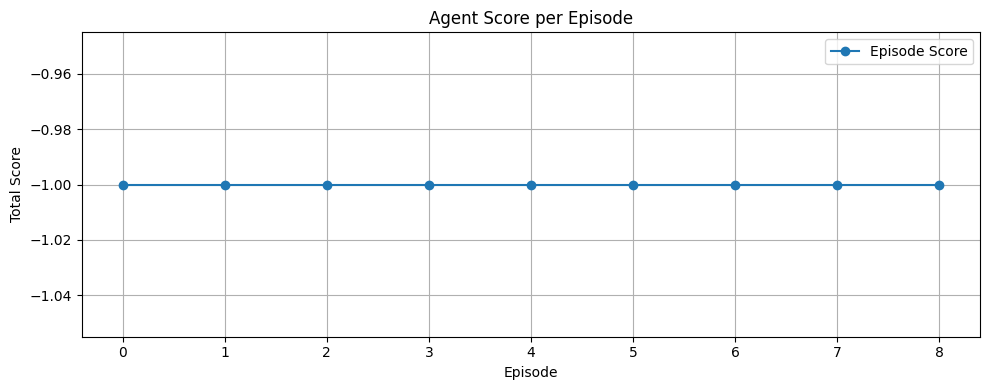

In [62]:
from rich.live import Live
from rich.table import Table
from rich.console import Console
from collections import deque
import matplotlib.pyplot as plt
import random
import sys
from absl import flags

flags.FLAGS(sys.argv)  # fix required by pysc2
# from util import preprocess, legal_actions, make_pysc2_call
# from env import SC2Envs

console = Console()
envs = SC2EnvsMulti(nb_actor=1)
pending_action = [None] * envs.nb

MAX_ROWS = 20
recent_rows = deque(maxlen=MAX_ROWS)

# For tracking per-episode scores
episode_score = [0] * envs.nb
scores = []

def generate_table():
    table = Table(title=f"SC2 Agent Actions (Last {MAX_ROWS} Steps)", expand=True)
    table.add_column("Step", justify="right")
    table.add_column("Function ID", justify="right")
    table.add_column("Args", justify="left")
    for row in recent_rows:
        table.add_row(*row)
    return table

with Live(generate_table(), refresh_per_second=10, console=console, transient=True) as live:
    for step in range(MAX_ITERS):
        for i in range(envs.nb):
            ts = envs.obs[i]

            if pending_action[i]:
                action, pending_action[i] = make_pysc2_call(None, ts, pending_action[i])
            else:
                legal = legal_actions(ts)
                action_idx = random.choice(legal)
                action, pending_action[i] = make_pysc2_call(action_idx, ts)

            recent_rows.append((str(step), str(action.function), str(action.arguments)))
            live.update(generate_table())

            ts = envs.step(i, action)
            episode_score[i] += ts.reward

            if ts.last():
                scores.append(episode_score[i])
                episode_score[i] = 0  # reset
                envs.reset(i)

envs.close()

# Plot episode scores
plt.figure(figsize=(10, 4))
plt.plot(reward, label="Episode Score", marker='o', linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Total Score")
plt.title("Agent Score per Episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
